# Отчёт по лабораторной работе №6 "Кластеризация"

In [2]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering

DATA_FILE_NAME_1 = 'Lab 6/ex6data1'
DATA_FILE_NAME_2 = 'Lab 6/bird_small'

Imports from 'common' file:

In [3]:
import os
from scipy.io import loadmat

DATA_DIRECTORY = '../Data/'
CUSTOM_DATA_DIRECTORY = '../CustomData/'


def load_data_from_mat_file(filename, directory=DATA_DIRECTORY):
    filepath = directory + f'{filename}.mat'
    return loadmat(filepath)

### 1. Загрузите данные ​ ex6data1.mat ​ из файла.

In [4]:
df_data = load_data_from_mat_file(DATA_FILE_NAME_1)
df_1 = pd.DataFrame({'x1': df_data['X'][:, 0], 'x2': df_data['X'][:, 1]})
X = df_1[['x1', 'x2']]

### 2. Реализуйте функцию случайной инициализации K центров кластеров.

In [5]:
def get_initial_cluster_centrals(X, claster_count):
    return X[np.random.choice(X.shape[0], claster_count, replace=False)]


### 3. Реализуйте функцию определения принадлежности к кластерам.

In [6]:
def get_clusters(X, centroids):
    D = []
    for centroid in centroids:
        D.append(np.square(X - centroid).sum(axis=1))

    return np.argmin(np.array(D).T, axis=1)

### 4. Реализуйте функцию пересчета центров кластеров.

In [7]:
def update_centroids(X, clusters, K):
    new_centroids = np.zeros((K, X.shape[1]))
    for k in range(K):
        if len(X[clusters == k]) == 0:
            continue

        new_centroids[k] = X[clusters == k].mean(axis=0)

    return new_centroids

### 5. Реализуйте алгоритм K-средних.

In [8]:
def k_means_algorithm(X, K):
    centroids = get_initial_cluster_centrals(X, K)
    clusters = get_clusters(X, centroids)
    centroids_history = [centroids]

    while True:
        currrent_centroids = update_centroids(X, clusters, K)
        current_clusters = get_clusters(X, currrent_centroids)
        centroids_history.append(currrent_centroids)
        if (centroids_history[-1] == centroids_history[-2]).all():
            break

    return current_clusters, np.array(centroids_history)


def cost_func(X, c, centroids):
    M = X.shape[0]
    cost = 0
    for i in range(M):
        cost += np.square(X[i] - centroids[int(c[i])]).sum()

    return cost / M


def k_means(X, K, iteration_count=100):
    best_cost = np.inf
    best_result = None

    for i in range(iteration_count):
        clusters, centroids_history = k_means_algorithm(X, K)
        cost = cost_func(X, clusters, centroids_history[-1])

        if cost < best_cost:
            best_result = (clusters, centroids_history)
            best_cost = cost

    return best_result, best_cost


### 6. Постройте график, на котором данные разделены на K=3 кластеров (при помощи различных маркеров или цветов), а также траекторию движения центров кластеров в процессе работы алгоритма

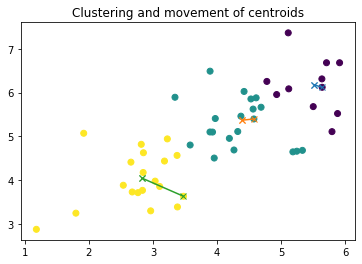

In [9]:
(best_clusters, best_centroids_history), best_cost = k_means(X.values, 3)

plt.scatter(X.x1, X.x2, c=best_clusters)

plt.plot(
  *[best_centroids_history[:, i, j] for i in range(len(best_centroids_history)) for j in range(2)], marker='x')
plt.title('Clustering and movement of centroids')
plt.show()


### 7. Загрузите данные ​ bird_small.mat ​ из файла.

In [10]:
df_data = load_data_from_mat_file(DATA_FILE_NAME_2)
A = df_data['A']

### 8. С помощью алгоритма K-средних используйте 16 цветов для кодирования пикселей.

In [14]:
def compress(A, colors_count=16):
    X = np.reshape(A, [A.shape[0] * A.shape[1], A.shape[2]])
    (best_clusters, best_centroids_history), best_cost = k_means(X, colors_count, iteration_count=1)
    new_colors = np.round(best_centroids_history[-1]).astype(np.uint8)

    image = X.copy()
    for i in range(X.shape[0]):
        image[i, :] = new_colors[best_clusters[i]]

    return image.reshape(A.shape)


compressed_A = compress(A)

### 9. Насколько уменьшился размер изображения? Как это сказалось на качестве?

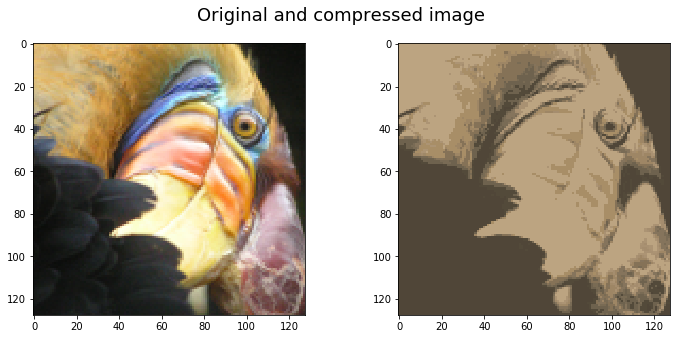

In [15]:
fig, axs = plt.subplots(ncols=2, figsize=[12, 5])
fig.suptitle("Original and compressed image", fontsize=18)
axs[0].imshow(A)
axs[1].imshow(compressed_A)
plt.show()

Каждый пиксель сжатого изображения представляется 4-мя битами (0..15 в десятичной СС), поэтому сжатое
изображение имеет размер 128*128 * 4 / 8 байт, что равняется 8192 байт.

Пиксель оригинальное изображение, в свою очередь представляется 8-ю битами, то есть 1-м байтов, а значит оно
будет иметь размер 128*128 байт, что равняется 16384 байт. Следовательно сжатое изображение имеет в два раза
меньший размер.

Как видим, качество изображения пострадало, однако по-прежнему легко различимо, что это попугай.

### 10.Реализуйте алгоритм K-средних на другом изображении.

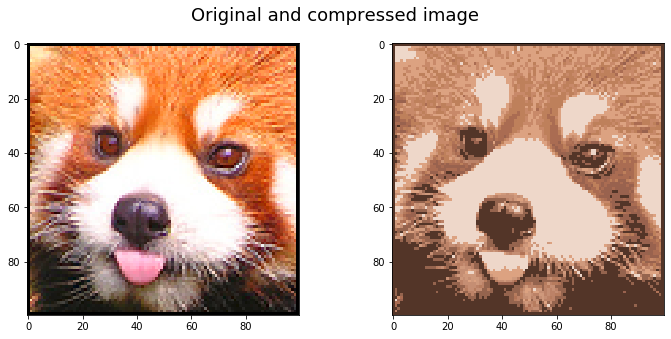

In [16]:
im = Image.open(CUSTOM_DATA_DIRECTORY + '6/imageExample.png')
img = np.array(im.convert('RGB'))
compressed_img = compress(img)

fig, axs = plt.subplots(ncols=2, figsize=[12, 5])
fig.suptitle("Original and compressed image", fontsize=18)
axs[0].imshow(img)
axs[1].imshow(compressed_img)
plt.show()

### 11.Реализуйте алгоритм иерархической кластеризации на том же изображении. Сравните полученные результаты.

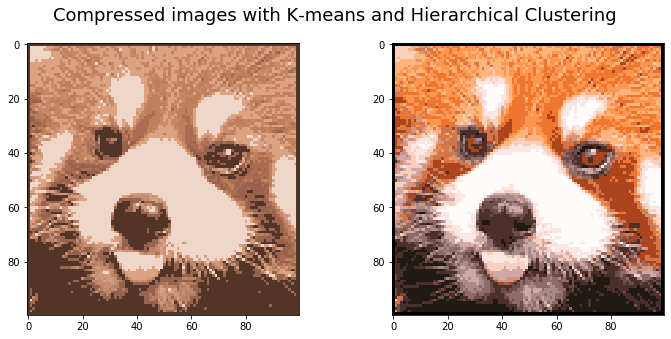

In [19]:
def compress_hierarchical_clusters(img, n_colors=16):
    X = np.reshape(img, [img.shape[0] * img.shape[1], img.shape[2]])

    cluster = AgglomerativeClustering(n_clusters=n_colors, affinity='euclidean', linkage='ward')
    cluster.fit(X)
    labels = cluster.labels_
    centroids = update_centroids(X, labels, n_colors).reshape((n_colors, 3))
    new_colors = np.round(centroids).astype(np.uint8)

    image = X.copy()
    for i in range(X.shape[0]):
        image[i, :] = new_colors[labels[i]]

    return image.reshape(img.shape)


compressed_hierarchicaly_img = compress_hierarchical_clusters(img)

fig, axs = plt.subplots(ncols=2, figsize=[12, 5])
fig.suptitle("Compressed images with K-means and Hierarchical Clustering", fontsize=18)
axs[0].imshow(compressed_img)
axs[1].imshow(compressed_hierarchicaly_img)
plt.show()

В данном примере используется агломеративный метод иерархической кластеризации, то есть метод, при котором
новые кластеры создаются путем объединения более мелких кластеров и, таким образом, дерево создается от листьев
к стволу.

Как видим, результат получились достаточно схож с результатом алгоритма K-средних. Это связано с тем, что был
использован метод Уорда, с помощью которого расстояние между кластерами высчитывается на основе дисперсии, то
есть минимизируется квадрат расстояния между объектами. А это, в свою очередь, очень похоже на метод, с помощью
которого минимизируется функция стоимости в реализованном алгоритме K-средних.